# Generating Tabular Data via XGBoost Models with Flow-Matching

This notebook is a self-contained example showing how to generate tabular data through XGBoost models trained with flow-matching [(Jolicoeur-Martineau et al. 2023)](https://arxiv.org/abs/2309.09968).

# Imports

In [ ]:
from sklearn.datasets import load_iris
import numpy as np
import copy
import xgboost as xgb
from functools import partial
from sklearn.preprocessing import MinMaxScaler
from joblib import delayed, Parallel
import matplotlib.pyplot as plt
import torch
from torchcfm.conditional_flow_matching import ConditionalFlowMatcher

As example, we use [Iris](https://en.wikipedia.org/wiki/Iris_flower_data_set), a classic tabular dataset about flowers with 150 observations, 4 input continuous variables (sepal length, sepal width, petal length, and petal width), and 1 categorical outcome variable (3 categories of flowers; setosa, versicolor, and virginica).

In [ ]:
# Iris: numpy dataset with 4 variables (all numerical) and 1 outcome (categorical; 3 categories)
my_data = load_iris()
X, y = my_data['data'], my_data['target']

# shuffle the observations
new_perm = np.random.permutation(X.shape[0])
np.take(X, new_perm, axis=0, out=X)
np.take(y, new_perm, axis=0, out=y)

# Save data before adding missing values
X_true, y_true = copy.deepcopy(X), copy.deepcopy(y)
Xy_true = np.concatenate((X_true, np.expand_dims(y_true, axis=1)), axis=1)

In [ ]:
X[0:10]

array([[6.3, 2.7, 4.9, 1.8],
       [5. , 3.3, 1.4, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [5.5, 2.4, 3.7, 1. ],
       [5.6, 3. , 4.1, 1.3],
       [6.5, 3.2, 5.1, 2. ],
       [6.3, 2.8, 5.1, 1.5],
       [4.3, 3. , 1.1, 0.1],
       [5.6, 3. , 4.5, 1.5],
       [6.3, 2.3, 4.4, 1.3]])

In [ ]:
y[0:10]

array([2, 0, 0, 1, 1, 2, 2, 0, 1, 1])

We set the hyperparameters here.

In [ ]:
# Main hyperparameters
n_t=50 # number of flow steps (higher is better, 50 is enough for great performance)
duplicate_K=100 # number of different noise sample per real data sample (higher is better)

# XGBoost hyperparameters
max_depth=7
n_estimators=100
eta=0.3
tree_method='hist'
reg_lambda=0.0
reg_alpha=0.0
subsample=1.0

We do the data preprocessing, which includes min/max normalization and extracting the $x(t)$, $y$.

In [ ]:
# Save min/max of the values
X_min = np.nanmin(X, axis=0, keepdims=1)
X_max = np.nanmax(X, axis=0, keepdims=1)

# Min-Max scaling of the variables
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

# Save shape
b, c = X.shape

# we duplicate the data multiple times, so that X0 is k times bigger, so that we can have k random noise z associated per sample
X1 = np.tile(X_scaled, (duplicate_K, 1))

# Generate noise data
X0 = np.random.normal(size=X1.shape)

# Saving the freqency of the classes and storing label masks for later
y_uniques, y_probs = np.unique(y, return_counts=True)
y_probs = y_probs/np.sum(y_probs)
mask_y = {} # mask for which observations has a specific value of y
for i in range(len(y_uniques)):
  mask_y[y_uniques[i]] = np.zeros(b, dtype=bool)
  mask_y[y_uniques[i]][y == y_uniques[i]] = True
  mask_y[y_uniques[i]] = np.tile(mask_y[y_uniques[i]], (duplicate_K))
n_y = len(y_uniques) # number of classes

In [ ]:
torch.from_numpy(t).shape

torch.Size([15000])

In [ ]:
# Build [X(t), y] at multiple values of t

# Conditional Flow Matching
FM = ConditionalFlowMatcher(sigma=0.0)

# Time levels
t_levels = np.linspace(1e-3, 1, num=n_t)

# Interpolation between x0 and x1 (xt)
X_train = np.zeros((n_t, X0.shape[0], X0.shape[1])) # [n_t, b, c]

# Output to predict (ut)
y_train = np.zeros((n_t, X0.shape[0], X0.shape[1])) # [n_t, b, c]

# Fill with xt and ut
for i in range(n_t):
  t = torch.ones(X0.shape[0])*t_levels[i] # current t
  _, xt, ut = FM.sample_location_and_conditional_flow(torch.from_numpy(X0), torch.from_numpy(X1), t=t)
  X_train[i], y_train[i] = xt.numpy(), ut.numpy()

We train the $ckn_t$ XGBoost models, where $k$ is the number of classes (3), $c$ is the number of input variables (4), and $n_t$ is the number of time levels (50) .

In [ ]:
# Function used for training one model
def train_parallel(X_train, y_train):
  model = xgb.XGBRegressor(n_estimators=n_estimators, objective='reg:squarederror', eta=eta, max_depth=max_depth,
    reg_lambda=reg_lambda, reg_alpha=reg_alpha, subsample=subsample, seed=666, tree_method=tree_method, device='cpu')

  y_no_miss = ~np.isnan(y_train)
  model.fit(X_train[y_no_miss, :], y_train[y_no_miss])

  return model

In [ ]:
%%time
# Train all model(s); fast if you have a decent multi-core CPU, but extremely slow on Google Colab because it uses a weak 2-core CPU

regr = Parallel(n_jobs=-1)( # using all cpus
        delayed(train_parallel)(
          X_train.reshape(n_t, b*duplicate_K, c)[i][mask_y[j], :],
          y_train.reshape(n_t, b*duplicate_K, c)[i][mask_y[j], k]
          ) for i in range(n_t) for j in y_uniques for k in range(c)
        )

# Replace fits with doubly loops to make things easier
regr_ = [[[None for k in range(c)] for i in range(n_t)] for j in y_uniques]
current_i = 0
for i in range(n_t):
  for j in range(len(y_uniques)):
    for k in range(c):
      regr_[j][i][k] = regr[current_i]
      current_i += 1
regr = regr_

CPU times: user 22.4 s, sys: 1.01 s, total: 23.4 s
Wall time: 2min 33s


We generate data by solving the ODE.

In [ ]:
batch_size = 150 # number of generated samples

In [ ]:
# Return the flow at time t using the XGBoost models
def my_model(t, xt, mask_y=None):
  # xt is [b*c]
  xt = xt.reshape(xt.shape[0] // c, c) # [b, c]

  # Output from the models
  out = np.zeros(xt.shape) # [b, c]
  i = int(round(t*(n_t-1)))
  for j, label in enumerate(y_uniques):
    for k in range(c):
      out[mask_y[label], k] = regr[j][i][k].predict(xt[mask_y[label], :])

  out = out.reshape(-1) # [b*c]
  return out

In [ ]:
# Simple Euler ODE solver (nothing fancy)
def euler_solve(x0, my_model, N=100):
  h = 1 / (N-1)
  x_fake = x0
  t = 0
  # from t=0 to t=1
  for i in range(N-1):
    x_fake = x_fake + h*my_model(t=t, xt=x_fake)
    t = t + h
  return x_fake

In [ ]:
# Generate prior noise
x0 = np.random.normal(size=(batch_size, c))

# Generate random labels for the outcome
label_y_fake = y_uniques[np.argmax(np.random.multinomial(1, y_probs, size=x0.shape[0]), axis=1)]
mask_y_fake = {} # mask for which observations has a specific value of y
for i in range(len(y_uniques)):
  mask_y_fake[y_uniques[i]] = np.zeros(x0.shape[0], dtype=bool)
  mask_y_fake[y_uniques[i]][label_y_fake == y_uniques[i]] = True

# ODE solve
ode_solved = euler_solve(my_model=partial(my_model, mask_y=mask_y_fake), x0=x0.reshape(-1), N=n_t) # [t, b*c]
solution = ode_solved.reshape(batch_size, c) # [b, c]

# invert the min-max normalization
solution = scaler.inverse_transform(solution)

# clip to min/max values
small = (solution < X_min).astype(float)
solution = small*X_min + (1-small)*solution
big = (solution > X_max).astype(float)
solution = big*X_max + (1-big)*solution

# Concatenate the y label
Xy_fake = np.concatenate((solution, np.expand_dims(label_y_fake, axis=1)), axis=1)

We just generated fake tabular data! Lets now compare the two dataset (real vs fake).

In [ ]:
Xy_true[0:10] # Real data

array([[6.3, 2.7, 4.9, 1.8, 2. ],
       [5. , 3.3, 1.4, 0.2, 0. ],
       [4.8, 3. , 1.4, 0.1, 0. ],
       [5.5, 2.4, 3.7, 1. , 1. ],
       [5.6, 3. , 4.1, 1.3, 1. ],
       [6.5, 3.2, 5.1, 2. , 2. ],
       [6.3, 2.8, 5.1, 1.5, 2. ],
       [4.3, 3. , 1.1, 0.1, 0. ],
       [5.6, 3. , 4.5, 1.5, 1. ],
       [6.3, 2.3, 4.4, 1.3, 1. ]])

In [ ]:
Xy_fake[0:10] # Flow generated data

array([[7.70416404, 2.60770348, 6.89875937, 2.29975846, 2.        ],
       [5.71245456, 2.67784573, 4.46800527, 1.29312701, 1.        ],
       [6.90905257, 3.10365892, 4.89451653, 1.49655894, 1.        ],
       [6.09844165, 2.79924682, 4.67878266, 1.2643672 , 1.        ],
       [6.34161997, 2.50283022, 4.48071676, 1.29997651, 1.        ],
       [5.98187725, 2.9008275 , 4.55302671, 1.44861139, 1.        ],
       [6.69764819, 2.9995559 , 4.94228331, 1.63181927, 1.        ],
       [4.80603753, 3.10127567, 1.59940169, 0.19936797, 0.        ],
       [6.14561074, 2.71435588, 4.88747496, 1.80105514, 2.        ],
       [5.50153173, 4.20417377, 1.44317234, 0.40054388, 0.        ]])

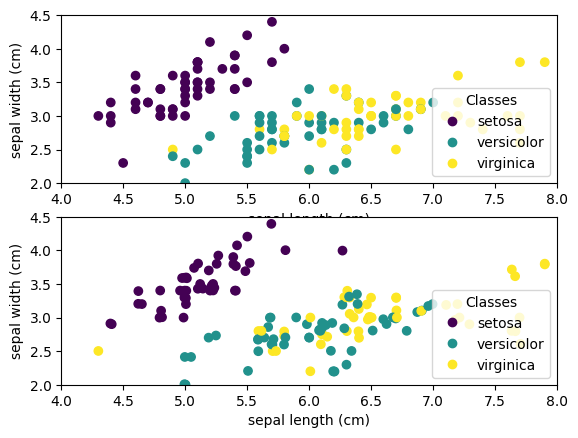

In [ ]:
_, (ax1, ax2) = plt.subplots(2)
# Real data
scatter = ax1.scatter(Xy_true[:, 0], Xy_true[:, 1], c=Xy_true[:,-1])
ax1.set(xlabel=my_data.feature_names[0], ylabel=my_data.feature_names[1], xlim=(4, 8), ylim=(2, 4.5))
_ = ax1.legend(scatter.legend_elements()[0], my_data.target_names, loc="lower right", title="Classes")
# Fake data
scatter = ax2.scatter(Xy_fake[:, 0], Xy_fake[:, 1], c=Xy_fake[:,-1])
ax2.set(xlabel=my_data.feature_names[0], ylabel=my_data.feature_names[1], xlim=(4, 8), ylim=(2, 4.5))
_ = ax2.legend(scatter.legend_elements()[0], my_data.target_names, loc="lower right", title="Classes")

Below we show how to do the same with the [ForestDiffusion pip package](https://github.com/SamsungSAILMontreal/ForestDiffusion).

In [ ]:
%%time
from ForestDiffusion import ForestDiffusionModel
forest_model = ForestDiffusionModel(X, label_y=y, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1, seed=1)
Xy_fake_ = forest_model.generate(batch_size=X.shape[0])

CPU times: user 9.98 s, sys: 1.56 s, total: 11.5 s
Wall time: 2min 36s


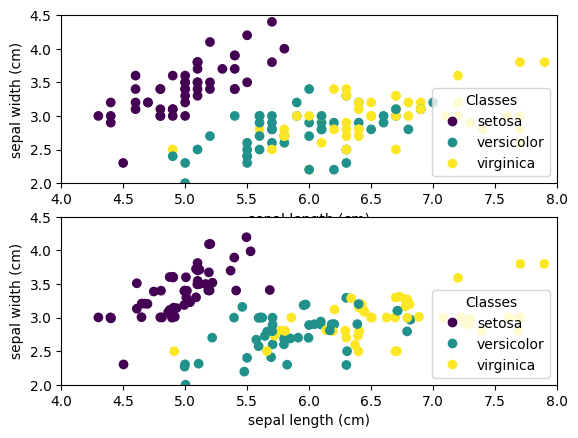

In [ ]:
_, (ax1, ax2) = plt.subplots(2)
# Real data
scatter = ax1.scatter(Xy_true[:, 0], Xy_true[:, 1], c=Xy_true[:,-1])
ax1.set(xlabel=my_data.feature_names[0], ylabel=my_data.feature_names[1], xlim=(4, 8), ylim=(2, 4.5))
_ = ax1.legend(scatter.legend_elements()[0], my_data.target_names, loc="lower right", title="Classes")
# Fake data
scatter = ax2.scatter(Xy_fake_[:, 0], Xy_fake_[:, 1], c=Xy_fake_[:,-1])
ax2.set(xlabel=my_data.feature_names[0], ylabel=my_data.feature_names[1], xlim=(4, 8), ylim=(2, 4.5))
_ = ax2.legend(scatter.legend_elements()[0], my_data.target_names, loc="lower right", title="Classes")